In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from scipy.stats import multivariate_normal

In [2]:
data = pd.read_csv('owid-covid-data.csv')

In [3]:
df = data[['date', 'total_cases', 'new_cases']][(data.location == 'Russia') & (data.date >= '2020-03-03')]
df.new_cases.replace(0, 1, inplace=True)

In [4]:
df['x'] = np.arange(df.shape[0])
df['x_2'] = df.x ** 2
df['bias'] = 1

In [5]:
df_train = df[df.x <= 50]
df_test = df[df.x > 50]

# Task 2

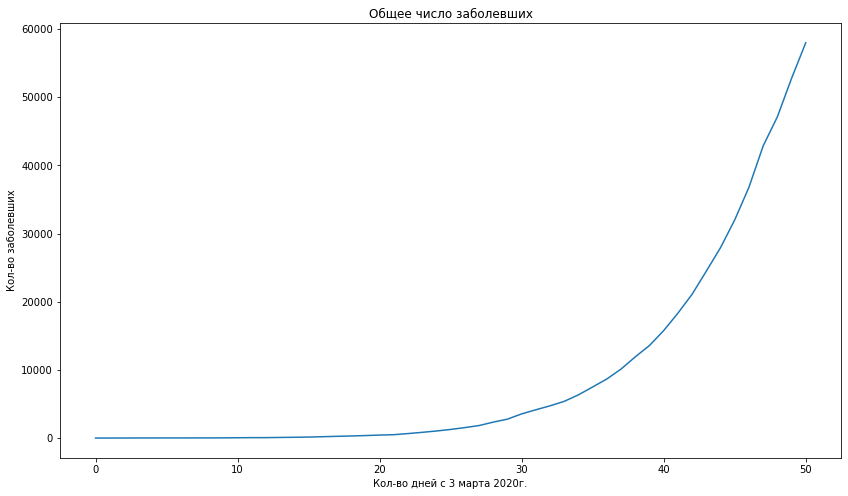

In [6]:
plt.figure(figsize=(14, 8))
plt.plot(df_train.x, df_train.total_cases)
plt.title("Общее число заболевших") 
plt.xlabel("Кол-во дней с 3 марта 2020г.") 
plt.ylabel("Кол-во заболевших")
plt.show()

In [7]:
model = linear_model.LinearRegression(fit_intercept=True,).fit(df_train[['x']], np.log(df_train.total_cases))

In [8]:
model.coef_[0], model.intercept_

(0.19655538808797077, 1.8490840448339725)

In [9]:
noise_std = np.std(
    np.log(df_train.total_cases) - model.coef_[0] * df_train.x.values - model.intercept_
)

In [10]:
noise_std

0.36069505053169026

In [11]:
N = 1000
MAX_X = 4
true_mu = [model.intercept_, model.coef_]

xs = np.linspace(-MAX_X, MAX_X, N)
X = np.linspace(-MAX_X, MAX_X, N)
Y = np.linspace(-MAX_X, MAX_X, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(true_mu[0], true_mu[1], marker='*', s=120)
    plt.show()

(1000, 1000)


<ipython-input-11-cbf76c0c21d0>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


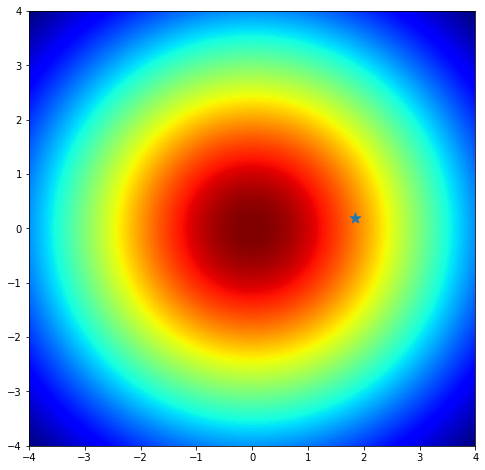

In [12]:
cur_mu, cur_sigma = np.array([0, 0]), 2 * MAX_X * np.array([[1, 0], [0, 1]], dtype = 'float')

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

plt.figure(figsize=(8, 8))
plt.xlim((xs[0], xs[-1]))
plt.ylim((-MAX_X, MAX_X))
myplot_heatmap(Z)

In [13]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.ones((x.shape[0], 2), dtype = 'float')
    x_matrix[:,1] = x
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(
        sigma_n, 
        np.matmul(
            np.linalg.inv(sigma), 
            np.transpose(mu)
        )[:, None] + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]).T) 
    )
    return mu_n[:,0], sigma_n

<ipython-input-11-cbf76c0c21d0>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


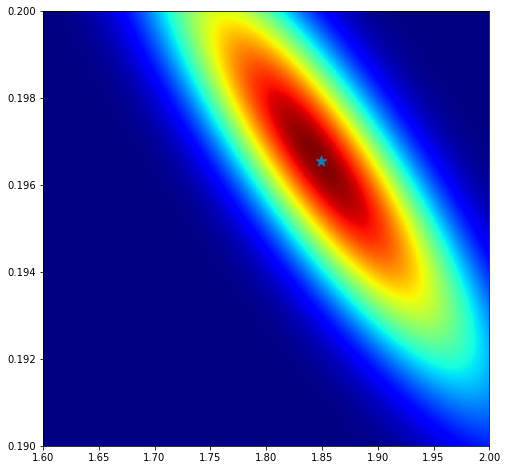

In [14]:
N = 1000
x_lim = (1.6, 2)
y_lim = (0.19, 0.2)
true_mu = [model.intercept_, model.coef_]

X = np.linspace(x_lim[0], x_lim[1], N)
Y = np.linspace(y_lim[0], y_lim[1], N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

px = df_train['x'].values
py = np.log(df_train.total_cases.values)

cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, noise_std)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

plt.figure(figsize=(8, 8))
plt.xlim(x_lim)
plt.ylim(y_lim)
myplot_heatmap(Z)

In [15]:
cur_mu, cur_sigma

(array([1.84680363, 0.19662305]),
 array([[ 9.89737696e-03, -2.93981382e-04],
        [-2.93981382e-04,  1.17630050e-05]]))

In [16]:
np.random.seed(0)
NUM_SAMPLE = 200
sample = np.random.multivariate_normal(cur_mu, cur_sigma, NUM_SAMPLE)
x = np.ones((2, df.shape[0]))
x[1] = np.arange(df.shape[0])
pred = sample @ x

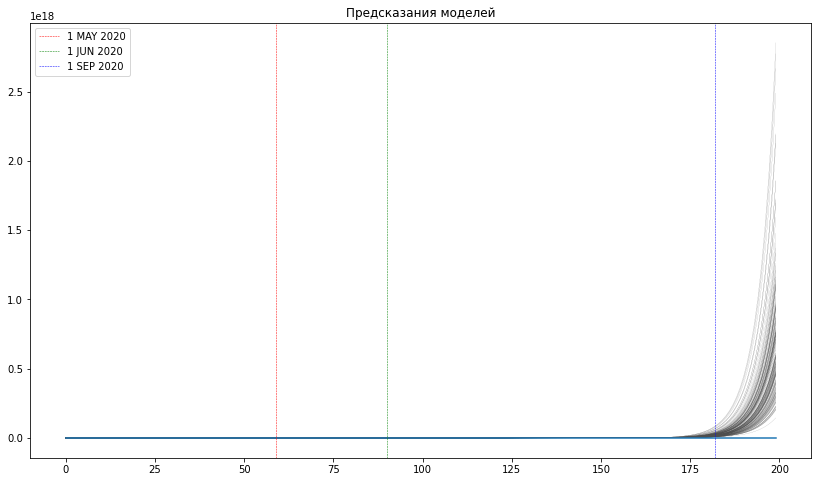

In [17]:
LIM = 200
may_1 = 59
jun_1 = 90
sep_1 = 182

plt.figure(figsize=(14, 8))
for el in pred:
    plt.plot(x[1, :LIM], np.exp(el[:LIM]), color='0.3', linewidth=.1)
plt.plot(x[1, :LIM], df.total_cases.values[:LIM])
plt.axvline(may_1, linestyle='--', linewidth=.5, color='r', label='1 MAY 2020')
plt.axvline(jun_1, linestyle='--', linewidth=.5, color='g', label='1 JUN 2020')
plt.axvline(sep_1, linestyle='--', linewidth=.5, color='b', label='1 SEP 2020')
plt.title('Предсказания моделей')
plt.legend()
plt.show()

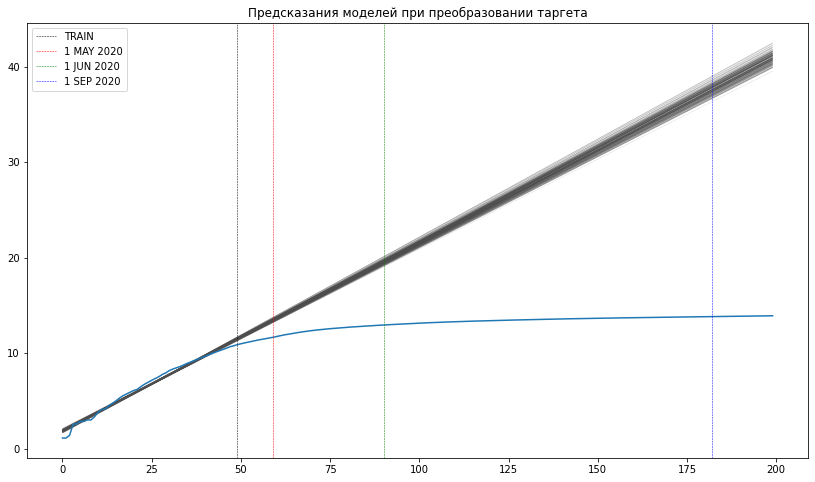

In [18]:
LIM = 200
may_1 = 59
jun_1 = 90
sep_1 = 182

plt.figure(figsize=(14, 8))
for el in pred:
    plt.plot(x[1, :LIM], el[:LIM], color='0.3', linewidth=.1)
plt.plot(x[1, :LIM], np.log(df.total_cases.values)[:LIM])
plt.axvline(49, linestyle='--', linewidth=.5, color='black', label='TRAIN')
plt.axvline(may_1, linestyle='--', linewidth=.5, color='r', label='1 MAY 2020')
plt.axvline(jun_1, linestyle='--', linewidth=.5, color='g', label='1 JUN 2020')
plt.axvline(sep_1, linestyle='--', linewidth=.5, color='b', label='1 SEP 2020')
plt.title('Предсказания моделей при преобразовании таргета')
plt.legend()
plt.show()

По графикам видно, что итоговая модель хорошо предсказывает данные на которых обучалась + дней 10 после границы обучающей выборки, дальше предсказания сильно больше, чем наблюдаемые значения - модель с экспонентой плохо описывает данные.

# Task3

Чтобы оценить сигмоиду с помощью линрега, достаточно взять производную от $y$, а зачем логарифм. Тогда можно будет оценить новый таргет $ y_{new} = ln(y') $ c помощью линрега от переменных $x^2, x, bias$, где $x$ - кол-во дней от 03.03.2020

В нашей задаче $y'$ лежит в колонке `new_cases`

In [19]:
TRAIN_LIMIT = 50
df_train = df[df.x < TRAIN_LIMIT]
df_test = df[df.x >= TRAIN_LIMIT]

In [20]:
model = linear_model.LinearRegression(fit_intercept=True,).fit(df_train[['x', 'x_2']], np.log(df_train.new_cases))

In [21]:
model.coef_[0], model.coef_[1], model.intercept_

(0.27562283190276415, -0.0018297906166869166, -0.3965904028416256)

In [22]:
noise_std = np.std(
    np.log(df_train.new_cases) - model.coef_[0] * df_train.x.values - model.coef_[1] * df_train.x_2.values -\
    model.intercept_
)

In [23]:
noise_std

0.4891695424595195

In [24]:
cur_mu, cur_sigma = np.array([0, 0, 0]), 2 * MAX_X * np.eye(3, dtype='float')

In [25]:
cur_mu, cur_sigma

(array([0, 0, 0]),
 array([[8., 0., 0.],
        [0., 8., 0.],
        [0., 0., 8.]]))

In [26]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.ones((x.shape[0], 3), dtype = 'float')
    x_matrix[:,1] = x
    x_matrix[:,2] = x ** 2
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(
        sigma_n, 
        np.matmul(
            np.linalg.inv(sigma), 
            np.transpose(mu)
        )[:, None] + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]).T) 
    )
    return mu_n[:,0], sigma_n

In [27]:
true_mu = [model.intercept_, model.coef_[0], model.coef_[1]]

px = df_train['x'].values
py = np.log(df_train.new_cases.values)

cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, noise_std)

In [28]:
cur_mu, cur_sigma

(array([-0.39451686,  0.27545204, -0.00182689]),
 array([[ 3.96034167e-02, -3.19969406e-03,  5.38665841e-05],
        [-3.19969406e-03,  3.53269815e-04, -6.74521001e-06],
        [ 5.38665841e-05, -6.74521001e-06,  1.37735111e-07]]))

In [29]:
np.random.seed(0)
NUM_SAMPLE = 200
sample = np.random.multivariate_normal(cur_mu, cur_sigma, NUM_SAMPLE)
x = np.ones((3, df.shape[0]))
x[1] = np.arange(df.shape[0])
x[2] = x[1] ** 2
pred = sample @ x

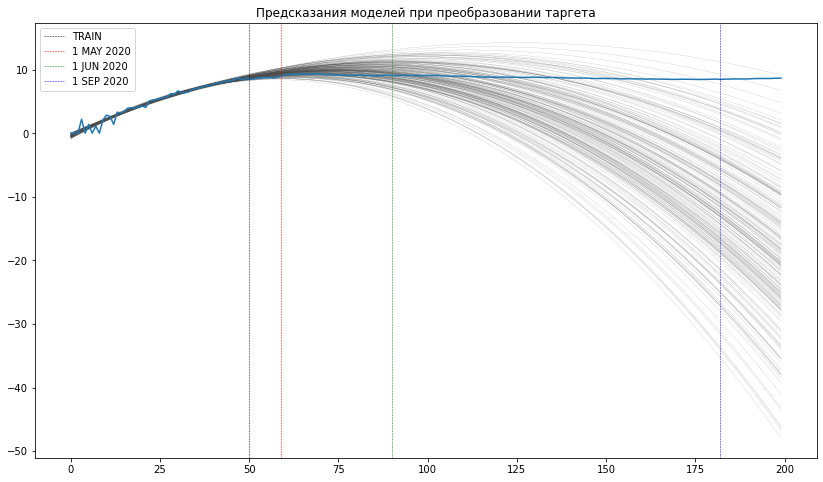

In [30]:
LIM = 200
may_1 = 59
jun_1 = 90
sep_1 = 182

plt.figure(figsize=(14, 8))
for el in pred:
    plt.plot(x[1, :LIM], el[:LIM], color='0.3', linewidth=.1)
plt.plot(x[1, :LIM], np.log(df.new_cases.values)[:LIM])
plt.axvline(TRAIN_LIMIT, linestyle='--', linewidth=.5, color='black', label='TRAIN')
plt.axvline(may_1, linestyle='--', linewidth=.5, color='r', label='1 MAY 2020')
plt.axvline(jun_1, linestyle='--', linewidth=.5, color='g', label='1 JUN 2020')
plt.axvline(sep_1, linestyle='--', linewidth=.5, color='b', label='1 SEP 2020')
plt.title('Предсказания моделей при преобразовании таргета')
plt.legend()
plt.show()

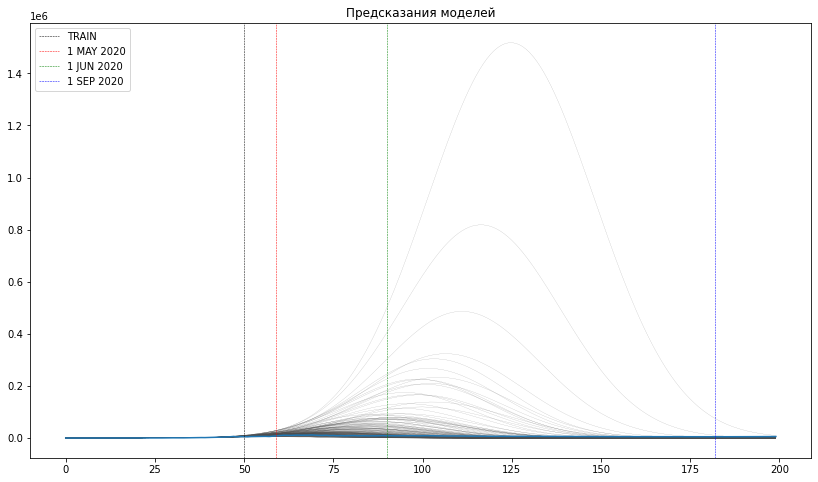

In [31]:
LIM = 200
may_1 = 59
jun_1 = 90
sep_1 = 182

plt.figure(figsize=(14, 8))
for el in pred:
    plt.plot(x[1, :LIM], np.exp(el[:LIM]), color='0.3', linewidth=.1)
plt.plot(x[1, :LIM], df.new_cases.values[:LIM])
plt.axvline(TRAIN_LIMIT, linestyle='--', linewidth=.5, color='black', label='TRAIN')
plt.axvline(may_1, linestyle='--', linewidth=.5, color='r', label='1 MAY 2020')
plt.axvline(jun_1, linestyle='--', linewidth=.5, color='g', label='1 JUN 2020')
plt.axvline(sep_1, linestyle='--', linewidth=.5, color='b', label='1 SEP 2020')
plt.title('Предсказания моделей')
plt.legend()
plt.show()

In [32]:
pred_cases = (np.cumsum(np.exp(pred[:, TRAIN_LIMIT:]), axis=1) + df.total_cases.values[TRAIN_LIMIT - 1]).astype(int)

In [33]:
date_pred = pred_cases[:, [may_1-TRAIN_LIMIT, jun_1-TRAIN_LIMIT, sep_1-TRAIN_LIMIT]]

In [34]:
print(f"""1 MAY 2020 true value - {int(df.total_cases.values[may_1])}, \
10 quantile - {int(np.quantile(date_pred[:, 0], 0.1))}, \
90 quantile - {int(np.quantile(date_pred[:, 0], 0.9))}""")

1 MAY 2020 true value - 114431, 10 quantile - 116569, 90 quantile - 201204


In [35]:
print(f"""1 JUN 2020 true value - {int(df.total_cases.values[jun_1])}, \
10 quantile - {int(np.quantile(date_pred[:, 1], 0.1))}, \
90 quantile - {int(np.quantile(date_pred[:, 1], 0.9))}""")

1 JUN 2020 true value - 414328, 10 quantile - 292795, 90 quantile - 2038746


In [36]:
print(f"""1 SEP 2020 true value - {int(df.total_cases.values[sep_1])}, \
10 quantile - {int(np.quantile(date_pred[:, 2], 0.1))}, \
90 quantile - {int(np.quantile(date_pred[:, 2], 0.9))}""")

1 SEP 2020 true value - 997072, 10 quantile - 305055, 90 quantile - 4120334
